Exercise 1: Implement K-Nearest Neighbor

In [1]:
#Load the data using pandas
#Import all the required packages
import pandas as pd
import numpy as np
import io
import requests
import matplotlib.pyplot as plt

#Reading the content from the HTML page using requests package
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
data = requests.get(url).content

#Splitting the data into rows and columns
cleanedData = data.decode('utf-8').split('\n')
rowsAndColumns = [each.split(',') for each in cleanedData]

#Adding a header to the data
header = ['sLength','sWidth','pLength','pWidth','class']
#The final dataframe
df = pd.DataFrame(rowsAndColumns, columns = header)
df = df.loc[0:149,:]

print(df.tail())
#df.to_csv('Iris.csv')

    sLength sWidth pLength pWidth           class
145     6.7    3.0     5.2    2.3  Iris-virginica
146     6.3    2.5     5.0    1.9  Iris-virginica
147     6.5    3.0     5.2    2.0  Iris-virginica
148     6.2    3.4     5.4    2.3  Iris-virginica
149     5.9    3.0     5.1    1.8  Iris-virginica


In [2]:
#Converting values ro numeric
numeric = ['sLength','sWidth','pLength','pWidth']
for each in numeric:
    df[each] = df[each].astype('float')
print(df.describe())

          sLength      sWidth     pLength      pWidth
count  150.000000  150.000000  150.000000  150.000000
mean     5.843333    3.054000    3.758667    1.198667
std      0.828066    0.433594    1.764420    0.763161
min      4.300000    2.000000    1.000000    0.100000
25%      5.100000    2.800000    1.600000    0.300000
50%      5.800000    3.000000    4.350000    1.300000
75%      6.400000    3.300000    5.100000    1.800000
max      7.900000    4.400000    6.900000    2.500000


In [3]:
#Checking for na values in any rows
print("NA's present : ",df.isnull().any().any())

NA's present :  False


In [4]:
#Train/Test split
from sklearn.model_selection import train_test_split

x = df.loc[:,df.columns != 'class']
y = df.loc[:,df.columns == 'class']

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.30, random_state=15)

#Used for cross validation
train = pd.concat([xTrain, yTrain], axis=1)
test = pd.concat([xTest, yTest], axis=1)

In [5]:
#Euclidean distance
def distance(xTrain,yTrain,xTest):
    dist,Class = [],[]
    for i in range(len(xTrain)):
        x = np.array(xTrain.iloc[i])
        y = np.array(yTrain.iloc[i])
        temp = float(np.sqrt(np.square(x-xTest).sum()))
        dist.append(temp)
        Class.append(str(y))
    result = pd.DataFrame({'dist': dist,'class':Class})
    return(result)

In [6]:
#K Nearest Neighbors
def nearestNeighbor(xTrain,yTrain,xTest,k):
    predicted = []
    for i in range(len(xTest)):
        xNew = np.array(xTest.iloc[i])
        dis = distance(xTrain,yTrain,xNew)
        dis = dis.sort_values(by='dist', ascending=1)
        knn = dis[:k]
        classPredicted = (knn['class'].value_counts()).sort_values(ascending=False)
        predicted.append(classPredicted.idxmax())
    return(predicted)

In [7]:
def accuracy(predicted,yTest):
    predictedNew = []
    #Cleaning predicted values
    for each in predicted:
        each = each.split("'")
        predictedNew.append(each[1])
    
    yTestNew = yTest['class'].tolist()
    total = len(yTestNew)
    true,false = 0,0
    
    #Comparing predicted to yTest to compute accuracy
    for each,every in zip(yTestNew,predictedNew):
        if each == every:
            true += 1
    return(float(true/total))

In [8]:
#Calling kNN function and computing accuracy
predicted = nearestNeighbor(xTrain,yTrain,xTest,2)
accu = accuracy(predicted,yTest)
print("Accuracy for 2 nearest neighbor is ",accu)

Accuracy for 2 nearest neighbor is  0.9777777777777777


Exercise 2: Optimize and Compare KNN algorithm

Part A : Determine Optimal Value of K in KNN algorithm

In [9]:
#defining grid values for k
kGrid = np.arange(1,50,2)
print(kGrid)

[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47 49]


In [10]:
#returns the test and train data for each fold of cross validation
def cvTestTrain(trainA,testFold,totalFolds):
    trainCv = pd.DataFrame([])
    testCv = pd.DataFrame([])
    #Extracting column names
    cols = trainA.columns.values
    #Removing colunm names
    trainA.columns = [''] * len(trainA.columns)
    #Data split to folds
    batch = np.array_split(trainA,totalFolds)
    key = 1
    trainDict = {}
    #Creating the test fold
    for each in batch:
        trainDict[key] = each
        key = key + 1
    testCv = trainDict[testFold]
    testCv.columns = cols
    #Creating train fold
    for key in range(1,6):
        if(key != testFold):
            trainCv = trainCv.append(trainDict[key])
    #Adding the column names to merged train datset
    trainCv.columns = cols
    return(trainCv,testCv)

In [11]:
#CrossValidation
def cv(trainCvalid,kGrid,totalFolds):
    k,acc = [],[]
    for eachK in kGrid:
        k.append(eachK)
        eachFoldAccuracy = []
        for each in range(1,totalFolds+1):
            trainC = trainCvalid.copy()
            trainCv,testCv = cvTestTrain(trainC,each,totalFolds)
            xTrain = trainCv.loc[:,testCv.columns != 'class']
            yTrain = trainCv.loc[:,testCv.columns == 'class']
            xTest = testCv.loc[:,testCv.columns != 'class']
            yTest = testCv.loc[:,testCv.columns == 'class']
            predicted = nearestNeighbor(xTrain,yTrain,xTest,eachK)
            accu = accuracy(predicted,yTest)
            eachFoldAccuracy.append(accu)
        temp = (np.mean(eachFoldAccuracy))
        acc.append(float(temp))
    return(k,acc)

In [12]:
#Computing optimal k-fold value with cross-validation
k1,accuracy1 = cv(train,kGrid,5)   

In [13]:
#Storing result in df
result = pd.DataFrame(
    {'k': k1,
     'acc': accuracy1
    })

Optimal k value is  15.0


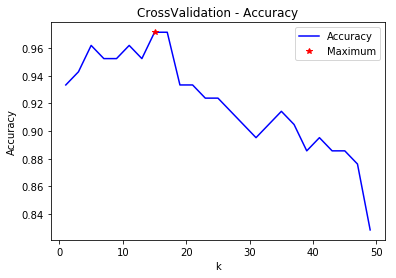

In [14]:
#Plotting the k vs Accuracy
plt.plot(result['k'],result['acc'],color = 'b',label = "Accuracy")
#Optimal k-value with max accuracy
optimal = result.iloc[result['acc'].idxmax()]
kOptimal = optimal['k']
accOptimal = optimal['acc']
plt.plot(kOptimal,accOptimal,'*',color = 'r',label = "Maximum")
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('CrossValidation - Accuracy')
plt.legend()
print("Optimal k value is ",kOptimal)
plt.show()

Optimal k value is  15.0


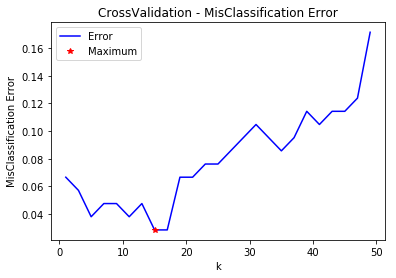

In [15]:
#Plotting the k vs MisClassification Rate
result['mis'] = 1 - result['acc']
plt.plot(result['k'],result['mis'],color = 'b',label = "Error")
optimal = result.iloc[result['mis'].idxmin()]
kOptimal = optimal['k']
accOptimal = optimal['mis']
plt.plot(kOptimal,accOptimal,'*',color = 'r',label = "Maximum")
plt.xlabel('k')
plt.ylabel('MisClassification Error')
plt.title('CrossValidation - MisClassification Error')
plt.legend()
print("Optimal k value is ",kOptimal)
plt.show()

In [16]:
#Comparing accuracy for different k values
for k in range(1,50,2):
    predicted = nearestNeighbor(xTrain,yTrain,xTest,k)
    accu = accuracy(predicted,yTest)
    print("Accuracy is %f with %d folds" %(accu,k))

Accuracy is 0.977778 with 1 folds
Accuracy is 0.977778 with 3 folds
Accuracy is 0.977778 with 5 folds
Accuracy is 0.955556 with 7 folds
Accuracy is 0.977778 with 9 folds
Accuracy is 1.000000 with 11 folds
Accuracy is 1.000000 with 13 folds
Accuracy is 1.000000 with 15 folds
Accuracy is 1.000000 with 17 folds
Accuracy is 1.000000 with 19 folds
Accuracy is 0.977778 with 21 folds
Accuracy is 1.000000 with 23 folds
Accuracy is 0.977778 with 25 folds
Accuracy is 0.977778 with 27 folds
Accuracy is 0.977778 with 29 folds
Accuracy is 0.977778 with 31 folds
Accuracy is 0.977778 with 33 folds
Accuracy is 1.000000 with 35 folds
Accuracy is 0.977778 with 37 folds
Accuracy is 0.977778 with 39 folds
Accuracy is 0.977778 with 41 folds
Accuracy is 0.955556 with 43 folds
Accuracy is 0.955556 with 45 folds
Accuracy is 0.955556 with 47 folds
Accuracy is 0.955556 with 49 folds


Part B : Compare KNN algorithm with Tree based method

In [18]:
#Importing packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn import metrics
import warnings

#Initialize model
knn = KNeighborsClassifier(n_neighbors=3)

#Fit data to model
knn.fit(xTrain, np.array(yTrain).ravel())

#Predicting values for test data
expected = yTest
predicted = knn.predict(xTest)

#Computing accuracy
print("Model summary",metrics.classification_report(expected, predicted))
print("\nConfusion Matrix",metrics.confusion_matrix(expected, predicted))
print ("\nAccuracy",accuracy_score(expected, predicted))

Model summary                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       1.00      0.94      0.97        16
 Iris-virginica       0.93      1.00      0.97        14

    avg / total       0.98      0.98      0.98        45


Confusion Matrix [[15  0  0]
 [ 0 15  1]
 [ 0  0 14]]

Accuracy 0.977777777778


In [19]:
#Initializing tree model
model = DecisionTreeClassifier()

#Fit data
model.fit(xTrain, yTrain)
print(model)

# make predictions
expected = yTest
predicted = model.predict(xTest)

# summarize the fit of the model
print("Model summary",metrics.classification_report(expected, predicted))
print("\nConfusion Matrix",metrics.confusion_matrix(expected, predicted))
print("\nAccuracy",accuracy_score(expected, predicted))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Model summary                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.94      1.00      0.97        16
 Iris-virginica       1.00      0.93      0.96        14

    avg / total       0.98      0.98      0.98        45


Confusion Matrix [[15  0  0]
 [ 0 16  0]
 [ 0  1 13]]

Accuracy 0.977777777778


In [20]:
#Grid search for kNN
warnings.filterwarnings("ignore")

#Creating a dict with param values
parameters1 = {'n_neighbors':kGrid}

#Base model
knn = KNeighborsClassifier()

#CrossValidation
grid1 = GridSearchCV(knn,param_grid = parameters1,cv=5,scoring='accuracy')
grid1.fit(xTrain, yTrain)

resultKnn = pd.DataFrame(grid1.cv_results_)

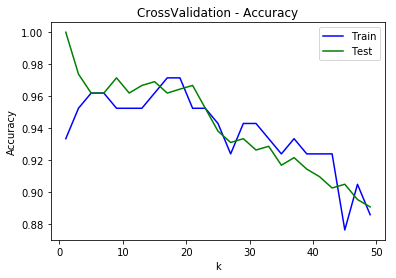

In [21]:
#Plotting values of cv
plt.plot(resultKnn['param_n_neighbors'],resultKnn['mean_test_score'],color = 'b',label = "Train")
plt.plot(resultKnn['param_n_neighbors'],resultKnn['mean_train_score'],color = 'g',label = "Test")
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('CrossValidation - Accuracy')
plt.legend()
plt.show()

In [22]:
#Fitting train data to best value to k-value
a = grid1.best_params_
b = a['n_neighbors']

knnNew = KNeighborsClassifier(n_neighbors=b)
knnNew.fit(xTrain, np.array(yTrain).ravel())

expected = yTest
predicted = knnNew.predict(xTest)

print("Model summary",metrics.classification_report(expected, predicted))
print("\nConfusion Matrix",metrics.confusion_matrix(expected, predicted))
print ("\nAccuracy",accuracy_score(expected, predicted))

Model summary                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       1.00      1.00      1.00        16
 Iris-virginica       1.00      1.00      1.00        14

    avg / total       1.00      1.00      1.00        45


Confusion Matrix [[15  0  0]
 [ 0 16  0]
 [ 0  0 14]]

Accuracy 1.0


In [23]:
#Grid search for decision tree
parameters2 = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 5, 10, 15, 20, 25, 30, 40, 50],
              "max_depth": [None, 2, 5, 10, 15, 20, 25, 30, 40, 50],
              "min_samples_leaf": [1, 5, 10, 15, 20],
              "max_leaf_nodes": [None, 5, 10, 20, 30, 40, 50],
              }

#Base model
treeNew = DecisionTreeClassifier()

#cv
grid2 = GridSearchCV(treeNew,param_grid = parameters2,cv=7,scoring='accuracy')
grid2.fit(xTrain, yTrain)
resultKnn = pd.DataFrame(grid2.cv_results_)

In [24]:
#Fitting data to decision tree with best hyper parameters
a = grid2.best_params_
modelTreeCv = DecisionTreeClassifier(criterion = a['criterion'],max_depth = a['max_depth'],max_leaf_nodes = a['max_leaf_nodes'],min_samples_leaf = a['min_samples_leaf'],min_samples_split = a['min_samples_split'])
modelTreeCv.fit(xTrain, yTrain)
print(modelTreeCv)

# make predictions
expected = yTest
predicted = modelTreeCv.predict(xTest)

# summarize the fit of the model
print("model summary",metrics.classification_report(expected, predicted))
print("\nConfusion Matrix",metrics.confusion_matrix(expected, predicted))
print ("\nAccuarcy",accuracy_score(expected, predicted))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
model summary                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.94      1.00      0.97        16
 Iris-virginica       1.00      0.93      0.96        14

    avg / total       0.98      0.98      0.98        45


Confusion Matrix [[15  0  0]
 [ 0 16  0]
 [ 0  1 13]]

Accuarcy 0.977777777778


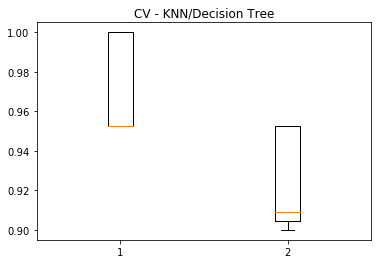

In [32]:
#Validating cv scores
from sklearn.cross_validation import cross_val_score
validated1 = cross_val_score(knnNew, xTrain, np.array(yTrain).ravel(), cv = 5, scoring = 'accuracy')
#print(validated1)

validated2 = cross_val_score(modelTreeCv, xTrain, np.array(yTrain).ravel(), cv = 5, scoring = 'accuracy')
#print(validated2)

plt.boxplot([validated1,validated2])
plt.title('CV - KNN/Decision Tree')
plt.show()